## Задача
В первой лабораторной вам предлагается решить задачу классификации изображений на два класса: хотдог и не-хотдог.


## Данные
    -Вы будете работать с подмножеством того самого Imagenet'a, который обеспечил прорыв в глубоком обучении. Изображения hotdog'a соответствуют классу hotdog в Imagenet'e, изображения для not_hotdog -- случайные изображения из остальных классов.
    -В обучающей выборке 1772 изображения (hotdog -- 739, not_hotdog -- 1033).
    -В тестовой выборке 350 изображений, пропорция классов примерно такая же как и в обучающей выборке. 
    Ground truth разметка для тестовой выборки не дана.
    -Сами данные: https://drive.google.com/file/d/1Xub8jbleCBXuLr8P6olxLCC5F2mw1UBu/view?usp=sharing



#### Как сдать работу
    -Пришлите мне на почту:
        Отчёт о проделанной работе и исходный код, в духе лабораторных работ в прошлом модуле.
        Файл test_labels.txt -- предсказание вашего финального классификатора на тестовой выборке. В файле должно быть 350 строк, в каждой строке имя файла и через пробел предсказанная метка (0 -- not_hotdog, 1 -- hotdog).  Например:
       00000.jpg 1
       00001.jpg 0
       00002.jpg 0
       00003.jpg 1
          ...
    В теме письма укажите: "DL Lab 1 Имя Фамилия", где вместо Имя Фамилия укажите ваши реальные Имя и Фамилию, например, DL Lab 1 Ян Лекун.
    Дедлайн: 11 июня, 23:59.

#### Разное
      -Работу нужно делать индивидуально.
      -Можно писать на любом языке (программирования).
      -Для выполнения работы можно использовать любые сторонние библиотеки, любые фреймворки для глубокого обучения, любые визуальные среды для машинного обучения и т.д.

Работа объёмная, времени мало, сети тренируются долго, поэтому начните делать работу  заранее.

## Что нужно сделать
- [max 2 балла]    Обучите классический алгоритм машинного обучения для этих данных (например, SVM, Random Forest или Gradient Boosting Trees), используя RGB-интенсивности пикселей в качестве входного вектора для классификации. Оцените ошибку.
- [max 3 балла]    Обучите свёрточную нейронную сеть на этих данных и оцените ошибку. Можно это делать на базе одного из базовых туторилов из фреймворка по глубокому обучению. Фреймворк можно использовать любой, но рекомендуется выбрать один из следующих: PyTorch, Keras, Mxnet/Gluon, Tensorflow (используя высокоуровневый интерфейс).
- [max 3 балла]    Обучите линейный SVM на features от предобученного VGG и оцените ошибку. А именно надо взять выходы от предпоследнего полносвязного слоя (то есть не того, который выдаёт предсказание на 1000 классов, а перед ним -- в котором 4096 нейронов) и использовать их в качестве входов для линейного SVM. В качестве сети VGG можно взять любой из вариантов (например, VGG-16 или VGG-19).
- [max 2 балла]    Выберите, как вы считатете, наиболее перспективный подход для этой задачи (выбор обоснуйте) и улучшите его точность. Классифицируете тестовую выборку, используя ваш финальный классификатор.

## Импорт основных библиотек

In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import os

from tqdm import tqdm_notebook as tqdm


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

## Предобработка данных
Прежде чем приступить к обучению различных моделей, следует научиться работать с изображениями

В самом начале, мне пришлось столкнуться с проблемой "битых" изображений, решением стало отлов битых данных и удаление их из обучающего и проверочного датасетов

In [2]:
def rm_trash_images(dir_path):
    for root, subdirs, files in os.walk(dir_path):
        for img in files:
            try:
                image_curr = Image.open("/".join([root, img]))
            except OSError:
                os.remove("/".join([root, img]))

rm_trash_images("../dl_hotdog_data/test/")
rm_trash_images("../dl_hotdog_data/train/")

Теперь, можно воспользоваться API pytorch, с его помощью мы:
- построим пайплайн обработки изображений для тестовой и обучающей выборки
- промаркируем наши изображения (хот-дог\ не хот-дог)
- отделим от обучающей выборки 20% на валидацию

In [3]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()])

trainset = torchvision.datasets.ImageFolder("../dl_hotdog_data/train", transform=transform_train)
val_size = int(len(trainset.imgs)*0.2)
train_size = len(trainset.imgs) - val_size 
trainset, valset = torch.utils.data.dataset.random_split(trainset, [train_size, val_size]) 

testset = torchvision.datasets.ImageFolder("../dl_hotdog_data/test", transform=transform_test)
testloader = torch.utils.data.DataLoader(testset)

In [4]:
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=4)
valloader = torch.utils.data.DataLoader(valset, shuffle=False, batch_size=1)

In [5]:
classes = trainloader.dataset.dataset.classes

Проверим, что у нас получилось:

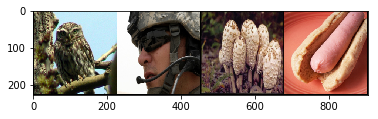

not_hotdog not_hotdog not_hotdog hotdog


In [12]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
plt.show()
print(" ".join([classes[it] for it in labels.numpy()]))

Теперь можно приступить к обучению различных моделей

## [max 2 балла] Классические алгоритмы
Обучить классический алгоритм машинного обучения (например, SVM, Random Forest или Gradient Boosting Trees), используя RGB-интенсивности пикселей в качестве входного вектора для классификации. Оценить ошибку.

# Dataset preprocessing

Для начала прервратим тензоры в одномерные numpy массивы, тк классические алгоритмы не работают с многомерным представлением признаков

In [6]:
trainloader = torch.utils.data.DataLoader(trainset)
valloader = torch.utils.data.DataLoader(valset)

In [7]:
def get_plain_dataset_from_loader(loader):
    X_, y_ = [], []
    for image_, label_ in tqdm(loader):
        X_.append(image_.view(224*224*3).numpy())
        y_.append(label_.numpy()[0])
    return X_, y_ 

In [8]:
X, y = get_plain_dataset_from_loader(trainloader)
X_val, y_val = get_plain_dataset_from_loader(valloader)
#     print(type(image), label)

## Train phase

Попробуем обучить 3 классических алгоритма:
 - Support Vector Machine
 - Random Forest
 - Stochastic Gradient Descent

In [9]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

### SVM
Начнем с машины опорных векторов, для подбора гиперпараметров используем RandomizedSearchCV

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC


In [40]:
svm_model = SVC(random_state=123)

In [52]:
param_dist = {"C": [1,2,4,5,7,9,13],
              "class_weight": ["balanced", None],
              "tol": [1e-3, 1e-2, 1e-4],
              "kernel": ["rbf", "poly", "sigmoid", "linear"]}

In [53]:
n_iter_search = 20
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=2, pre_dispatch='2*n_jobs',
                                   random_state=123, return_train_score=True)

Так как алгоритм на моем компьютере работает довольно медленно (примерно 2 минуты на прогон выборик из 400 картинок), подбор параметров будем осуществлять на подвыборке около 400 элементов

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
_, X_search, _, y_search = train_test_split(X, y, test_size=0.3)
len(X_search)

401

In [56]:
%%time
random_search.fit(X_search, y_search)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.768 (std: 0.023)
Parameters: {'tol': 0.01, 'kernel': 'rbf', 'class_weight': 'balanced', 'C': 13}

Model with rank: 2
Mean validation score: 0.766 (std: 0.024)
Parameters: {'tol': 0.001, 'kernel': 'rbf', 'class_weight': None, 'C': 13}

Model with rank: 3
Mean validation score: 0.763 (std: 0.025)
Parameters: {'tol': 0.0001, 'kernel': 'rbf', 'class_weight': None, 'C': 9}

CPU times: user 51.4 s, sys: 35.2 s, total: 1min 26s
Wall time: 30min 1s


Полученные значения гиперпараметров используем на полных данных

In [57]:
svm_model_tuned = SVC(random_state=123, tol=0.001, kernel='rbf', class_weight="balanced", C=13)

In [58]:
%%time
svm_model_tuned.fit(X, y)

CPU times: user 3min 34s, sys: 646 ms, total: 3min 35s
Wall time: 3min 35s


SVC(C=13, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False)

In [11]:
from sklearn.metrics import accuracy_score

In [61]:
y_val_pred = svm_model_tuned.predict(X_val)

In [62]:
accuracy_score(y_val, y_val_pred)

0.7867867867867868

### Random Forest
Теперь рассмотрим случайный лес, без подбора гиперпараметров

In [28]:
rf_model = RandomForestClassifier(n_estimators=300, random_state=123, oob_score=True, n_jobs=2)

In [29]:
rf_model.fit(X, y)
y_val_pred = rf_model.predict(X_val)
acc = accuracy_score(y_val, y_val_pred)
print(acc)

0.7897897897897898


## [max 3 балла]    
Обучить свёрточную нейронную сеть и оценить ошибку. Можно это делать на базе одного из базовых туторилов из фреймворка по глубокому обучению. Фреймворк можно использовать любой, но рекомендуется выбрать один из следующих: PyTorch, Keras, Mxnet/Gluon, Tensorflow (используя высокоуровневый интерфейс).

# Custom CNN

Для работы с нейронными сетями мною был выбран PyTorch, в виду хорошей документации и python-like API

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [29]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5, padding=1)
        self.conv3 = nn.Conv2d(12, 24, 5, padding=1)
        self.fc1 = nn.Linear(16224, 400)
        self.fc2 = nn.Linear(400, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 16224)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x


net = BaselineCNN()

Архитектура бейзлайн сети -- модификация сети из официального туториала, были добавлены zero-paddings, дополнительный сверточный слой + увеличено общее количество каналов в свертках. Размер Батча для обучения = 6, тк на больших значениях сеть обучалась очень медленно

In [45]:
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=6)
valloader = torch.utils.data.DataLoader(valset, shuffle=False, batch_size=6)

In [46]:
def get_accuracy(network, loader):
    accuracy = 0.0
    for img, label in loader:
        label_hat = torch.argmax(network(img),dim=1).numpy()
        accuracy += np.sum(label.numpy() == label_hat)
    accuracy /= loader.dataset.indices.size()[0]
    return accuracy
#         print(label.numpy()[0]==label_hat[0])

In [51]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=3e-3/1.5, momentum=0.8)


In [52]:
%%time
best_val_accuracy = get_accuracy(net, valloader)

CPU times: user 11.6 s, sys: 1.84 s, total: 13.4 s
Wall time: 8.45 s


In [53]:
best_val_accuracy

0.8198198198198198

In [ ]:
lr = 3e-3/1.5
for epoch in tqdm(range(40)):  # loop over the dataset multiple times
    
    if epoch % 10 == 9:
        lr/=1.5
        optimizer.param_groups[0]['lr']=lr
    running_loss = 0.0
    for inputs, labels in trainloader:

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        
    loss = running_loss / len(trainloader)
    val_accuracy = get_accuracy(net, valloader)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        print("New best validation accuracy: {0} !".format(best_val_accuracy))
        torch.save(net, "best_baseline_cnn.pt")
    print('Epoch {0}, loss: {1}, learning rate:{2}'.format(epoch + 1, loss, lr))
    running_loss = 0.0
        
# torch.save(net, "my_best_ann.pkl")
print('Finished Training')

Epoch 1, loss: 0.552283849817755, learning rate:0.002
Epoch 2, loss: 0.5419412203166517, learning rate:0.002
Epoch 3, loss: 0.5310057924200067, learning rate:0.002
New best validation accuracy: 0.8348348348348348 !
Epoch 4, loss: 0.5257035409655806, learning rate:0.002


/home/pavel/.local/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type BaselineCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 5, loss: 0.5298181813661293, learning rate:0.002
Epoch 6, loss: 0.519911094096744, learning rate:0.002
Epoch 7, loss: 0.516433448935838, learning rate:0.002
New best validation accuracy: 0.8378378378378378 !
Epoch 8, loss: 0.5127859769113395, learning rate:0.002
Epoch 9, loss: 0.5188200361525531, learning rate:0.002
New best validation accuracy: 0.8408408408408409 !
Epoch 10, loss: 0.5134187005293209, learning rate:0.0013333333333333333
New best validation accuracy: 0.8468468468468469 !
Epoch 11, loss: 0.5030884010374813, learning rate:0.0013333333333333333
Epoch 12, loss: 0.5061750230233231, learning rate:0.0013333333333333333
Epoch 13, loss: 0.5018320094309581, learning rate:0.0013333333333333333
Epoch 14, loss: 0.501284733615114, learning rate:0.0013333333333333333
Epoch 15, loss: 0.5044841195703087, learning rate:0.0013333333333333333
Epoch 16, loss: 0.5024413479817822, learning rate:0.0013333333333333333
New best validation accuracy: 0.8498498498498499 !
Epoch 17, loss: 0.49

In [332]:
net = torch.load("best_baseline_cnn.pt")
val_accuracy = get_accuracy(net, valloader_batch)
val_accuracy

0.8138138138138138

### [max 3 балла]    
Обучить линейный SVM на признаках от предобученного VGG и оценить ошибку.

А именно надо взять выходы от предпоследнего полносвязного слоя (то есть не того, который выдаёт предсказание на 1000 классов, а перед ним -- в котором 4096 нейронов) и использовать их в качестве входов для линейного SVM. В качестве сети VGG можно взять любой из вариантов (например, VGG-16 или VGG-19).


In [4]:
from torchvision.models import vgg16
ann_model = vgg16(True)
for param in ann_model.parameters():
    param.requires_grad = False
    
ann_model.classifier = ann_model.classifier[:-1] 
# = torch.nn.Linear(in_features=4096, out_features=2, bias=True)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.classifier[-1].parameters(), lr=1e-2, momentum=0.9)

In [7]:
ann_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [14]:
def get_dataset_from_ann(dataloader, ann):
    ann_X = []
    ann_y = []
    for img, label in tqdm(dataloader):
        ann_X.append(ann_model(img).numpy()[0])
        ann_y.append(label.numpy()[0])
    return ann_X, ann_y

In [15]:
net_X, net_y = get_dataset_from_ann(trainloader, ann_model)

In [17]:
val_net_X, val_net_y = get_dataset_from_ann(valloader, ann_model)

In [16]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# GBT

In [42]:
%%time
gbt_model_logit = GradientBoostingClassifier(n_estimators=100)
gbt_model_logit = gbt_model_logit.fit(net_X, net_y)

CPU times: user 32.4 s, sys: 12.5 ms, total: 32.4 s
Wall time: 32.4 s


In [43]:
%%time
y_hat_val = gbt_model_logit.predict(val_net_X)
accuracy = np.sum(y_hat_val == val_net_y)/len(val_net_y)

CPU times: user 9.25 ms, sys: 0 ns, total: 9.25 ms
Wall time: 7.97 ms


In [44]:
accuracy

0.9009009009009009

# RandomForest

In [45]:
rf_model = RandomForestClassifier(n_estimators=200, n_jobs=4)

In [46]:
%%time
rf_model = rf_model.fit(net_X, net_y)

CPU times: user 5.88 s, sys: 16.8 ms, total: 5.89 s
Wall time: 1.7 s


In [47]:
%%time
y_hat_val = rf_model.predict(val_net_X)
accuracy = np.sum(y_hat_val == val_net_y)/len(val_net_y)

CPU times: user 91.9 ms, sys: 7.83 ms, total: 99.7 ms
Wall time: 112 ms


In [48]:
accuracy

0.9039039039039038

# SVM

## rbf kernel

In [65]:
svm_model = SVC(C=0.8, kernel="rbf")

In [66]:
%%time
svm_model = svm_model.fit(net_X, net_y)

CPU times: user 4.16 s, sys: 11.7 ms, total: 4.17 s
Wall time: 4.18 s


In [67]:
%%time
y_hat_val = svm_model.predict(val_net_X)
accuracy = np.sum(y_hat_val == val_net_y)/len(val_net_y)

CPU times: user 1.03 s, sys: 120 µs, total: 1.03 s
Wall time: 1.03 s


In [68]:
accuracy

0.9219219219219219

## poly kernel

In [89]:
svm_model = SVC(C=0.6, kernel="poly", degree=2)

In [90]:
%%time
svm_model = svm_model.fit(net_X, net_y)

CPU times: user 5.55 s, sys: 11.9 ms, total: 5.56 s
Wall time: 5.56 s


In [91]:
%%time
y_hat_val = svm_model.predict(val_net_X)
accuracy = np.sum(y_hat_val == val_net_y)/len(val_net_y)

CPU times: user 1.37 s, sys: 262 µs, total: 1.37 s
Wall time: 1.37 s


In [92]:
accuracy

0.8948948948948949

## sigmoid kernel

In [113]:
svm_model = SVC(C=0.5, kernel="sigmoid")

In [114]:
%%time
svm_model = svm_model.fit(net_X, net_y)

CPU times: user 3.3 s, sys: 16.2 ms, total: 3.32 s
Wall time: 3.31 s


In [115]:
%%time
y_hat_val = svm_model.predict(val_net_X)
accuracy = np.sum(y_hat_val == val_net_y)/len(val_net_y)

CPU times: user 793 ms, sys: 3.75 ms, total: 797 ms
Wall time: 797 ms


In [116]:
accuracy

0.9129129129129129

In [ ]:
net_b = torch.load("my_best_ann_b.pkl")
val_accuracy = get_accuracy(net_b, valloader_batch)
val_accuracy